
### 금리_단기1년전차이

```
'번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       '금리_단기1년전차이', '평수', '동', '아파트ID', '아파트ID거리', '가까운공원ID', 'is_test',
       '학군'
       
28513
```

In [37]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from backup.module.preprocess import drop_columns

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'}) # 폰트 설정
plt.rc('font', family='AppleGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# sys.path를 수정하여 모듈 경로를 설정
import sys
import os
import pandas as pd

# 프로젝트 루트 경로 추가
project_root = os.path.abspath("..")
sys.path.append(project_root)
# 모든 컬럼 출력 설정
# pd.set_option('display.max_columns', None)
# 모든 행 출력 설정
# pd.set_option('display.max_rows', None)

import module

In [3]:
df, df_test_y = module.file_load.load_current_version()

In [4]:
df['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

is_test
0    1097155
1       5607
Name: count, dtype: int64

In [5]:
df.columns

Index(['index', '시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층',
       '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', '금리_단기1년전차이',
       'nearest_subway_distance', 'nearest_bus_distance', '1차역세권', '2차역세권',
       '1차버스정류장', '경과연도', '경과구분', '평수', '층_그룹', '평수_그룹', '시', '구', '동',
       '아파트ID', '아파트ID거리', 'nearest_park_distance', '가까운공원이름', '가까운공원ID',
       '공원갯수', '공원총면적', '공원생활권점수', '산책로갯수', '산책로총길이', '산책생활권점수', '생태문화길갯수',
       '생태문화길총길이', '생태문화생활권점수', '한강지천길갯수', '한강지

In [6]:
# 결측치가 많거나 필요 없는 컬럼을 정리한다
drop_columns = [
    'index', '시군구',  '본번', '부번', 
      '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)',
       'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)',
       'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적',
       'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하',
       'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
    
       '사용허가여부', '관리비 업로드','단지신청일', 
       'nearest_subway_distance', 'nearest_bus_distance', '1차역세권', '2차역세권',
       '1차버스정류장', '경과연도', '경과구분',  '층_그룹', '평수_그룹', '시',
        'nearest_park_distance',
    '가까운공원이름', 
        '공원생활권점수',
        '산책로갯수',
        '산책로총길이',
        '산책생활권점수',
        '생태문화길갯수',
        '생태문화길총길이',
        '생태문화생활권점수',
        '한강지천길갯수',
        '한강지천길총길이',
        '숲세권종합점수',
        '숲세권등급',
        '한강거리',
        '지가지수',
        '아파트전세_전기대비증감률',
        '실업률',
        '민간소비',
        '소비자심리지수',
        '경제심리지수',
        '여수신 금리차',
        '계약일',
        '전용면적(㎡)',
        '공원갯수',
        '공원총면적',
        '한강지천생활권점수'
]

# 전처리

In [7]:
df_select = module.preprocess.drop_columns(df, drop_columns)

In [8]:
module.preprocess.번지_본번_부번_결측채우기(df_select)
module.preprocess.한강거리_add(df_select)

In [9]:
df_select.columns

Index(['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       '금리_단기1년전차이', '평수', '구', '동', '아파트ID', '아파트ID거리', '가까운공원ID', 'is_test',
       '한강거리'],
      dtype='object')

# 파생변수

In [10]:
gangnam_8_schools = ['강남구', '서초구', '송파구']
df_select['학군'] = df_select['구'].apply(lambda x: 1 if x in gangnam_8_schools else 0)

In [11]:
final_drop_columns = ['구']
df_select.drop(final_drop_columns, axis=1, inplace=True)

# Model Training

## 범주형 변수 Encoding

In [12]:
model_data = df_select.copy()

In [13]:
model_data.columns

Index(['번지', '아파트명', '계약년월', '층', '건축년도', '도로명', '좌표X', '좌표Y', 'target',
       '금리_단기1년전차이', '평수', '동', '아파트ID', '아파트ID거리', '가까운공원ID', 'is_test',
       '한강거리', '학군'],
      dtype='object')

In [14]:
dt_train, dt_test = module.preprocess.split_train_test(model_data)
categorical_columns_v2 = module.preprocess.범주형_filter(dt_train)
label_encoders = module.preprocess.범주형_encoding(dt_train, dt_test, categorical_columns_v2)
print(dt_train.shape, dt_test.shape)

100%|██████████| 6/6 [00:01<00:00,  5.60it/s]

(1097155, 17) (5607, 17)


## Model Training


# 훈련데이터 분할

In [15]:
# X_train, X_val, y_train, y_val = module.preprocess.holdout_split_X_y_time_series(dt_train)

In [16]:
# X_train, X_val, y_train, y_val = module.preprocess.holdout_split_X_y(dt_train)

In [17]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((914296, 16), (182859, 16), (914296,), (182859,))

In [35]:
X_test = dt_test.drop(['target'], axis=1)


In [42]:
dt_train = dt_train.sort_values('계약년월')

In [60]:
model = lgb.LGBMRegressor(
    boosting_type='dart',  # 부스팅 타입 (기본값: 'gbdt')
    num_leaves=258,         # 리프 노드의 최대 개수 (기본값: 31)
    max_depth=8,          # 트리의 최대 깊이 (-1은 제한 없음)
    learning_rate=0.07224290084064122,     # 학습률 (기본값: 0.1)
    n_estimators=301,      # 부스팅 반복 횟수 (기본값: 100)
    min_child_samples=5,  # 자식 노드를 분할하기 위한 최소 데이터 수 (기본값: 20)
    subsample=0.9773487107075421,         # 데이터 샘플링 비율 (기본값: 1.0)
    colsample_bytree=0.9011817947068029,  # 트리 생성 시 feature 샘플링 비율 (기본값: 1.0)
    reg_alpha=0.04063525938772354,
    reg_lambda=0.0014482851327836004,
    random_state=42        # 랜덤 시드
)

In [64]:
y = dt_train['target']
X = dt_train.drop(['target'], axis=1)

In [65]:
# cv별로 학습하는 함수
tscv = TimeSeriesSplit(n_splits=10)
rmse_list = []
model_name = 'time09'
for _, (train_idx, val_idx) in tqdm(enumerate(tscv.split(X), start=1), desc=f'{model_name} Cross Validations...', total=10):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    clf = model.fit(X_train, y_train)
    
    pred = clf.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val, pred))
    rmse_list.append(rmse)

time09 Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 99745, number of used features: 16
[LightGBM] [Info] Start training from score 34375.996210
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

time09 Cross Validations...:  10%|█         | 1/10 [00:12<01:48, 12.04s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2736
[LightGBM] [Info] Number of data points in the train set: 199486, number of used features: 16
[LightGBM] [Info] Start training from score 41868.827056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  20%|██        | 2/10 [00:32<02:15, 17.00s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2767
[LightGBM] [Info] Number of data points in the train set: 299227, number of used features: 16
[LightGBM] [Info] Start training from score 43376.927022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  30%|███       | 3/10 [00:57<02:25, 20.85s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2795
[LightGBM] [Info] Number of data points in the train set: 398968, number of used features: 16
[LightGBM] [Info] Start training from score 43667.761003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  40%|████      | 4/10 [01:30<02:33, 25.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2809
[LightGBM] [Info] Number of data points in the train set: 498709, number of used features: 16
[LightGBM] [Info] Start training from score 44104.114979
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  50%|█████     | 5/10 [02:11<02:34, 30.92s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2823
[LightGBM] [Info] Number of data points in the train set: 598450, number of used features: 16
[LightGBM] [Info] Start training from score 44742.105563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  60%|██████    | 6/10 [03:06<02:36, 39.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2836
[LightGBM] [Info] Number of data points in the train set: 698191, number of used features: 16
[LightGBM] [Info] Start training from score 45954.462972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  70%|███████   | 7/10 [04:09<02:21, 47.16s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2849
[LightGBM] [Info] Number of data points in the train set: 797932, number of used features: 16
[LightGBM] [Info] Start training from score 47831.839109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  80%|████████  | 8/10 [05:17<01:47, 53.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 897673, number of used features: 16
[LightGBM] [Info] Start training from score 49967.452278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...:  90%|█████████ | 9/10 [07:13<01:13, 73.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 997414, number of used features: 16
[LightGBM] [Info] Start training from score 52944.591468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

time09 Cross Validations...: 100%|██████████| 10/10 [09:23<00:00, 56.39s/it]


In [59]:
# 검증 데이터로 예측
real_test_pred = model.predict(X_test)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(df_test_y, real_test_pred))}')
# s : RMSE test: 22522.447464776706
# 기존 한강거리 : 22000 , 22055

# 29208

RMSE test: 45031.72979337454


In [21]:
X_test.shape, real_test_pred.shape, df_test_y.shape

((5607, 16), (5607,), (5607, 1))

In [22]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

In [23]:
X_val = X_test.reset_index(drop=True)
X_val

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,금리_단기1년전차이,평수,동,아파트ID,아파트ID거리,가까운공원ID,한강거리,학군
0,1678,327,202301,10,1983,4465,127.068028,37.487802,2.25,22,8,1200,0.000000,1661,3113.804133,1
1,1665,328,202212,3,1983,471,127.072682,37.489122,2.25,25,8,1199,45.380282,1731,2867.571730,1
2,1665,328,202301,10,1983,471,127.072682,37.489122,2.50,25,8,1199,45.380282,1731,2867.571730,1
3,728,1933,202210,7,2019,4978,127.064151,37.480049,1.75,18,8,250,117.916314,1691,3968.559871,1
4,728,1933,202212,8,2019,4978,127.064151,37.480049,2.25,25,8,250,117.916314,1691,3968.559871,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,3322,36,202207,4,2021,5352,126.891951,37.584794,1.25,25,163,181,0.000000,747,2881.698680,0
5603,3322,36,202207,6,2021,5352,126.891951,37.584794,1.25,25,163,181,0.000000,747,2881.698680,0
5604,3322,36,202207,7,2021,5352,126.891951,37.584794,1.25,25,163,181,0.000000,747,2881.698680,0
5605,3322,36,202209,4,2021,5352,126.891951,37.584794,1.75,25,163,181,0.000000,747,2881.698680,0


In [24]:
X_val['target'] = df_test_y
X_val['pred'] = real_test_pred
X_val['예측차이'] = X_val['target'] - X_val['pred']
# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [25]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(1000)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(1000)       # 예측을 잘한 top 100개의 data

In [26]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [27]:
# error_top100.to_csv('7_한강_lgbm_error.csv', index=False)
# best_top100.to_csv('7_한강_lgbm_top.csv', index=False)

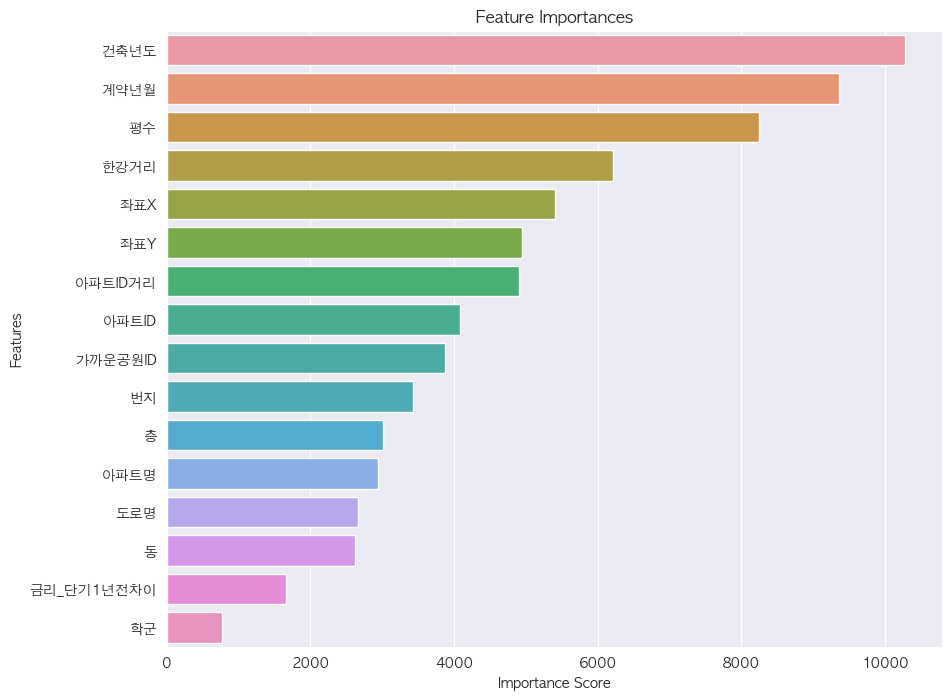

In [28]:
# Feature Importances 추출 및 정렬
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

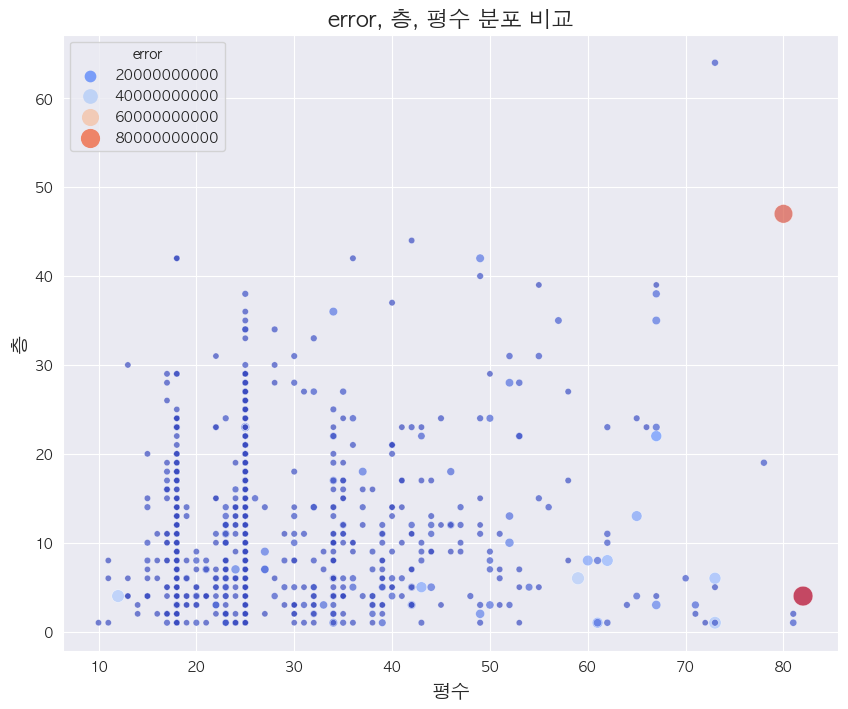

In [29]:
# 2D 히트맵으로 target, 층, 전용면적의 분포 비교
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=error_top100, 
    x='평수', 
    y='층', 
    size='error', 
    hue='error', 
    palette='coolwarm', 
    alpha=0.7, 
    sizes=(20, 200)
)
plt.title('error, 층, 평수 분포 비교', fontsize=16)
plt.xlabel('평수', fontsize=14)
plt.ylabel('층', fontsize=14)
plt.legend(title='error')
plt.grid(True)
plt.show()

In [30]:
print(error_top100['층'].value_counts().sort_values(ascending=False))
print(error_top100['평수'].value_counts())

층
4     73
2     56
1     56
6     55
8     53
3     53
7     49
5     46
10    46
12    45
11    42
15    42
9     41
14    37
13    36
17    31
19    29
16    27
20    21
18    19
21    18
22    18
23    18
24    17
29    10
27    10
28     8
25     8
26     6
42     4
31     4
34     3
30     3
35     3
38     2
33     2
36     2
39     2
40     1
64     1
47     1
37     1
44     1
Name: count, dtype: int64
평수
25    438
18    126
34     37
23     36
17     23
     ... 
54      1
60      1
12      1
59      1
72      1
Name: count, Length: 65, dtype: int64


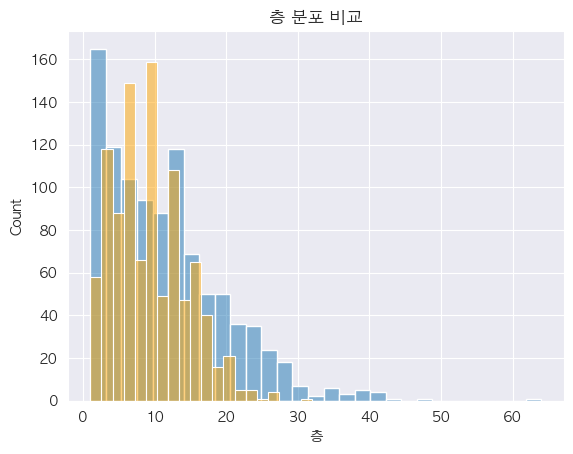

In [31]:
sns.histplot(data = error_top100, x='층', alpha=0.5)
sns.histplot(data = best_top100, x='층', color='orange', alpha=0.5)
plt.title('층 분포 비교')
plt.show()

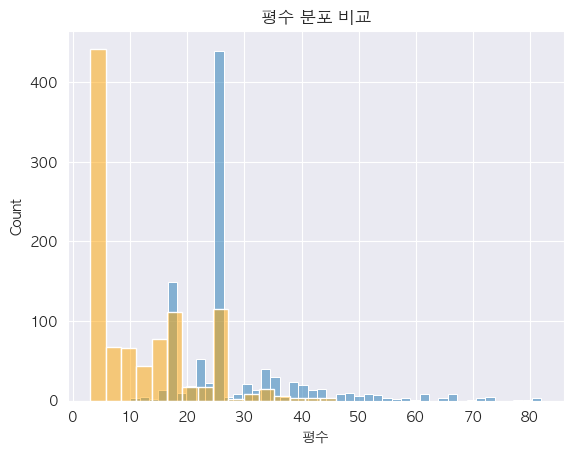

In [32]:
sns.histplot(data = error_top100, x='평수', alpha=0.5)
sns.histplot(data = best_top100, x='평수', color='orange', alpha=0.5)
plt.title('평수 분포 비교')
plt.show()

In [33]:
error_top100

,번지,아파트명,계약년월,층,건축년도,도로명,좌표X,좌표Y,금리_단기1년전차이,평수,동,아파트ID,아파트ID거리,가까운공원ID,한강거리,학군,target,pred,예측차이,error
2201,1496-24,트라움하우스3,202212,4,2002,명달로 97-14,127.002921,37.486202,2.25,82,서초동,A13784102,391.153802,P02373,2477.029577,1,640000.0,3.239483e+05,316051.718166,9.988869e+10
4881,685-700,아크로서울포레스트,202209,47,2020,왕십리로 83-21,127.043847,37.544464,1.75,80,성수동1가,A10024503,33.425547,P00357,1034.605382,0,1300000.0,1.002185e+06,297814.767050,8.869364e+10
3679,369-1,현대1차,202207,6,1976,압구정로29길 71,127.027926,37.533027,1.25,59,압구정동,A13589802,23.804947,P02575,215.420231,1,800000.0,6.081999e+05,191800.137739,3.678729e+10
54,189,개포주공4단지,202301,4,1982,삼성로 14,127.069985,37.485699,2.25,12,개포동,A10023348,172.878586,P02509,3260.120802,1,370000.0,1.822892e+05,187710.754240,3.523533e+10
4810,612-28,비버리힐즈,202207,1,1998,사평대로12길 27,126.992966,37.496919,1.75,73,반포동,A13783001,286.231418,P02477,1119.412412,1,450000.0,2.658027e+05,184197.267130,3.392863e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,779-8,구의현대홈시티,202301,18,2006,자양로 109,127.083069,37.537523,2.25,25,자양동,A10026720,176.519483,P00404,1504.519140,0,90000.0,1.145946e+05,-24594.642012,6.048964e+08
178,514,고덕롯데캐슬베네루체,202301,7,2019,상암로79길 88,127.167612,37.549416,2.25,18,상일동,A10025112,0.000000,P02932,2822.148106,0,95000.0,1.195786e+05,-24578.606409,6.041079e+08
610,748,마곡13단지힐스테이트마스터,202301,3,2017,마곡중앙1로 71,126.818285,37.557760,2.25,25,마곡동,A10026879,93.858087,P01790,3100.114058,0,109000.0,1.335753e+05,-24575.340766,6.039474e+08
141,701,강일리버파크8단지,202301,2,2009,아리수로94길 72,127.176270,37.560722,2.25,25,강일동,A13410002,102.668214,P02852,2074.475979,0,74300.0,9.886372e+04,-24563.715318,6.033761e+08


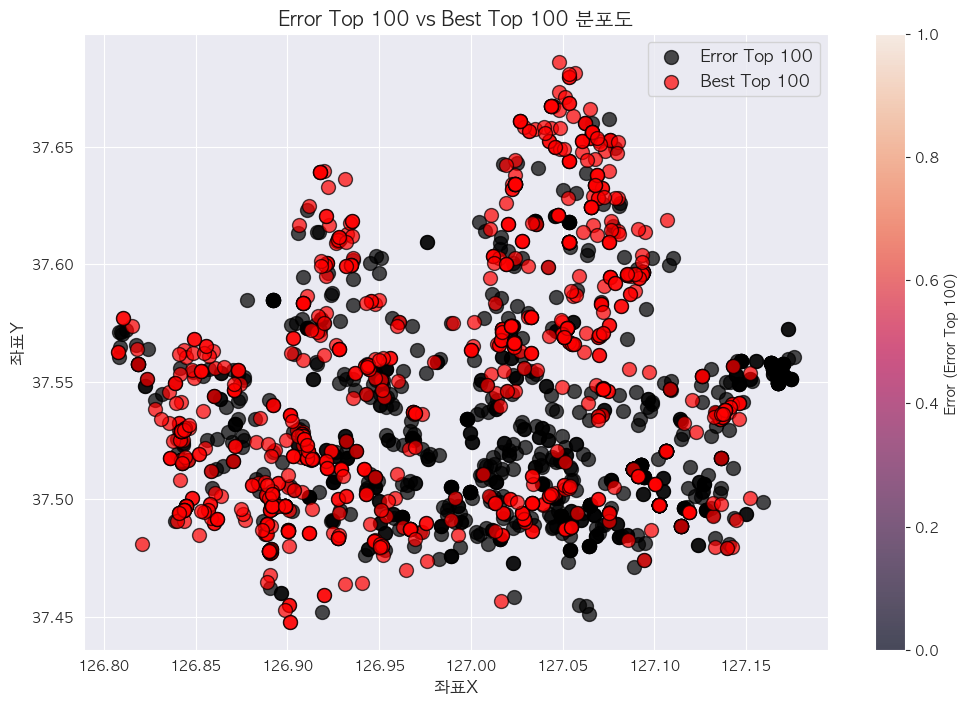

In [34]:

# 그래프 생성
plt.figure(figsize=(12, 8))

# error_top100 산점도
scatter1 = plt.scatter(
    error_top100['좌표X'], error_top100['좌표Y'], 
    c='black',  s=100, edgecolor='k', alpha=0.7, label='Error Top 100'
)

# best_top100 산점도
scatter2 = plt.scatter(
    best_top100['좌표X'], best_top100['좌표Y'], 
    c='red', s=100, edgecolor='k', alpha=0.7, label='Best Top 100'
)

# 컬러바 추가 (error_top100용)
plt.colorbar(scatter1, label='Error (Error Top 100)')

# 축 및 제목 설정
plt.xlabel('좌표X', fontsize=12)
plt.ylabel('좌표Y', fontsize=12)
plt.title('Error Top 100 vs Best Top 100 분포도', fontsize=14)
plt.grid(True)

# 범례 추가
plt.legend(fontsize=12)

# 그래프 표시
plt.show()